In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter


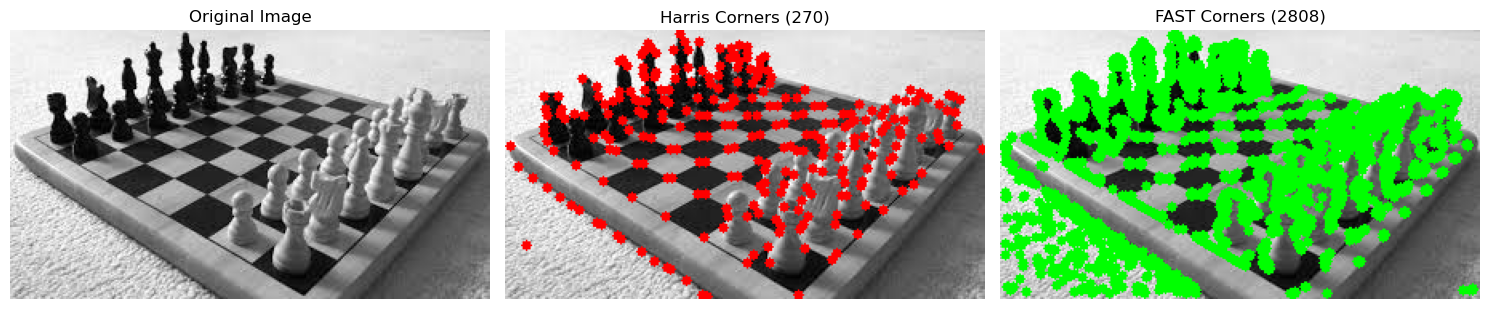

In [6]:
"""
feature_detectors.py

Expert-level implementation of:
1. Harris Corner Detector (from scratch)
2. FAST Corner Detector (from scratch)

Purpose:
- Computer Vision learning
- Academic demonstration
- Interview-ready implementation

No OpenCV corner APIs are used.
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter


# =============================================================================
#                         HARRIS CORNER DETECTOR
# =============================================================================

def harris_corner_detector(
    gray_img,
    window_size=3,
    k=0.04,
    threshold_ratio=0.01
):
    """
    Harris Corner Detector (from scratch)

    Args:
        gray_img (np.ndarray): Grayscale image (float32)
        window_size (int): Window size for structure tensor
        k (float): Harris constant
        threshold_ratio (float): Relative threshold

    Returns:
        list of (row, col)
    """

    # 1. Image gradients
    Ix = sobel(gray_img, axis=1)
    Iy = sobel(gray_img, axis=0)

    # 2. Gradient products
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    # 3. Gaussian smoothing
    Ixx = gaussian_filter(Ixx, sigma=1)
    Iyy = gaussian_filter(Iyy, sigma=1)
    Ixy = gaussian_filter(Ixy, sigma=1)

    # 4. Structure tensor summation
    offset = window_size // 2
    h, w = gray_img.shape

    Sxx = np.zeros_like(gray_img)
    Syy = np.zeros_like(gray_img)
    Sxy = np.zeros_like(gray_img)

    for y in range(offset, h - offset):
        for x in range(offset, w - offset):
            Sxx[y, x] = np.sum(Ixx[y-offset:y+offset+1, x-offset:x+offset+1])
            Syy[y, x] = np.sum(Iyy[y-offset:y+offset+1, x-offset:x+offset+1])
            Sxy[y, x] = np.sum(Ixy[y-offset:y+offset+1, x-offset:x+offset+1])

    # 5. Harris response
    det_M = Sxx * Syy - Sxy ** 2
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    # 6. Thresholding
    threshold = threshold_ratio * np.max(R)
    candidates = R > threshold

    # 7. Non-maximum suppression
    corners = []
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            if candidates[y, x]:
                if R[y, x] == np.max(R[y-1:y+2, x-1:x+2]):
                    corners.append((y, x))

    return corners


# =============================================================================
#                             FAST CORNER DETECTOR
# =============================================================================

def fast_corner_detector(
    gray_img,
    threshold=30,
    min_contiguous=9
):
    """
    FAST Corner Detector (correct contiguous arc test)

    Args:
        gray_img (np.ndarray): Grayscale uint8 image
        threshold (int): Intensity threshold
        min_contiguous (int): Minimum contiguous pixels

    Returns:
        list of (row, col)
    """

    if gray_img.dtype != np.uint8:
        gray_img = gray_img.astype(np.uint8)

    h, w = gray_img.shape
    corners = []

    # FAST-16 circle (radius = 3)
    circle = [
        (0, 3), (1, 3), (2, 2), (3, 1),
        (3, 0), (3, -1), (2, -2), (1, -3),
        (0, -3), (-1, -3), (-2, -2), (-3, -1),
        (-3, 0), (-3, 1), (-2, 2), (-1, 3)
    ]

    for y in range(3, h - 3):
        for x in range(3, w - 3):
            center = int(gray_img[y, x])

            states = []
            for dx, dy in circle:
                p = int(gray_img[y + dy, x + dx])
                if p >= center + threshold:
                    states.append(1)
                elif p <= center - threshold:
                    states.append(-1)
                else:
                    states.append(0)

            # Wrap-around continuity check
            states = states * 2

            max_bright = 0
            max_dark = 0
            curr_bright = 0
            curr_dark = 0

            for s in states:
                if s == 1:
                    curr_bright += 1
                    curr_dark = 0
                elif s == -1:
                    curr_dark += 1
                    curr_bright = 0
                else:
                    curr_bright = 0
                    curr_dark = 0

                max_bright = max(max_bright, curr_bright)
                max_dark = max(max_dark, curr_dark)

            if max_bright >= min_contiguous or max_dark >= min_contiguous:
                corners.append((y, x))

    return corners


# =============================================================================
#                                   DEMO
# =============================================================================

def main():
    image_path = r"C:\Users\11suj\Downloads\download (1).jpg"   # CHANGE PATH IF REQUIRED

    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("Image not found. Check image path.")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Harris
    harris_pts = harris_corner_detector(
        gray.astype(np.float32),
        window_size=3,
        k=0.04,
        threshold_ratio=0.01
    )

    # FAST
    fast_pts = fast_corner_detector(
        gray,
        threshold=30,
        min_contiguous=9
    )

    # Draw results
    img_harris = img.copy()
    img_fast = img.copy()

    for y, x in harris_pts:
        cv2.circle(img_harris, (x, y), 3, (0, 0, 255), -1)

    for y, x in fast_pts:
        cv2.circle(img_fast, (x, y), 3, (0, 255, 0), -1)

    # Visualization
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
    plt.title(f"Harris Corners ({len(harris_pts)})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_fast, cv2.COLOR_BGR2RGB))
    plt.title(f"FAST Corners ({len(fast_pts)})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


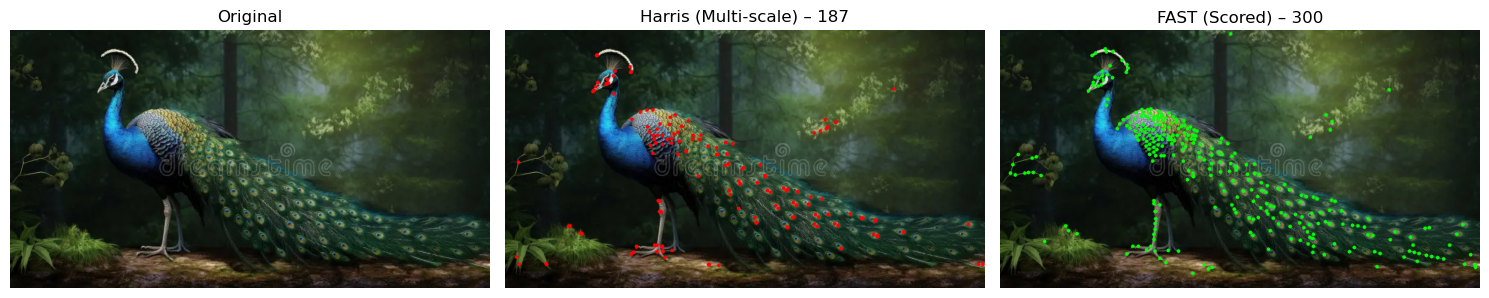

In [8]:
"""
advanced_feature_detectors.py

Advanced implementations of:
1. Harris Corner Detector (efficient, multi-scale, sub-pixel accurate)
2. FAST Corner Detector with scoring + NMS

Improvements implemented:
✔ Convolution-based neighborhood summation
✔ Tunable non-maximum suppression radius
✔ Adaptive / percentile-based thresholding
✔ Sub-pixel corner refinement
✔ Multi-scale Harris (Gaussian pyramid)
✔ Top-N strongest corners
✔ FAST scoring + score-based NMS
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import (
    sobel,
    gaussian_filter,
    uniform_filter,
    maximum_filter
)

# =============================================================================
#                           UTILITY FUNCTIONS
# =============================================================================

def non_max_suppression(response, radius):
    """Score-based non-maximum suppression"""
    local_max = maximum_filter(response, size=2 * radius + 1)
    return (response == local_max) & (response > 0)


def subpixel_refinement(R, y, x):
    """
    Sub-pixel corner refinement using quadratic fitting
    """
    if y <= 0 or x <= 0 or y >= R.shape[0] - 1 or x >= R.shape[1] - 1:
        return y, x

    dx = (R[y, x + 1] - R[y, x - 1]) / 2.0
    dy = (R[y + 1, x] - R[y - 1, x]) / 2.0
    dxx = R[y, x + 1] - 2 * R[y, x] + R[y, x - 1]
    dyy = R[y + 1, x] - 2 * R[y, x] + R[y - 1, x]

    if dxx != 0:
        x = x - dx / dxx
    if dyy != 0:
        y = y - dy / dyy

    return y, x


# =============================================================================
#                         MULTI-SCALE HARRIS DETECTOR
# =============================================================================

def harris_multiscale(
    gray,
    sigmas=(1.0, 2.0, 3.0),
    k=0.04,
    nms_radius=5,
    percentile=99.5,
    top_n=300
):
    """
    Multi-scale Harris Corner Detector with all enhancements
    """

    all_corners = []

    gray = gray.astype(np.float32)

    for sigma in sigmas:
        # --- Gradients ---
        Ix = sobel(gaussian_filter(gray, sigma), axis=1)
        Iy = sobel(gaussian_filter(gray, sigma), axis=0)

        # --- Structure tensor ---
        Ixx = gaussian_filter(Ix * Ix, sigma)
        Iyy = gaussian_filter(Iy * Iy, sigma)
        Ixy = gaussian_filter(Ix * Iy, sigma)

        # --- Efficient neighborhood summation ---
        Sxx = uniform_filter(Ixx, size=3)
        Syy = uniform_filter(Iyy, size=3)
        Sxy = uniform_filter(Ixy, size=3)

        # --- Harris response ---
        det = Sxx * Syy - Sxy ** 2
        trace = Sxx + Syy
        R = det - k * (trace ** 2)

        # --- Adaptive threshold ---
        thresh = np.percentile(R, percentile)
        R[R < thresh] = 0

        # --- Non-maximum suppression ---
        nms = non_max_suppression(R, nms_radius)

        ys, xs = np.where(nms)
        for y, x in zip(ys, xs):
            y_ref, x_ref = subpixel_refinement(R, y, x)
            all_corners.append((y_ref, x_ref, R[y, x]))

    # --- Sort and keep strongest ---
    all_corners.sort(key=lambda x: x[2], reverse=True)
    all_corners = all_corners[:top_n]

    return all_corners


# =============================================================================
#                           FAST DETECTOR (SCORED)
# =============================================================================

def fast_with_score(
    gray,
    threshold=30,
    min_contiguous=9,
    nms_radius=4,
    top_n=300
):
    """
    FAST detector with scoring + NMS
    """

    if gray.dtype != np.uint8:
        gray = gray.astype(np.uint8)

    h, w = gray.shape
    corners = []

    circle = [
        (0, 3), (1, 3), (2, 2), (3, 1),
        (3, 0), (3, -1), (2, -2), (1, -3),
        (0, -3), (-1, -3), (-2, -2), (-3, -1),
        (-3, 0), (-3, 1), (-2, 2), (-1, 3)
    ]

    score_map = np.zeros_like(gray, dtype=np.float32)

    for y in range(3, h - 3):
        for x in range(3, w - 3):
            center = int(gray[y, x])
            diffs = []

            for dx, dy in circle:
                p = int(gray[y + dy, x + dx])
                diffs.append(p - center)

            diffs = np.array(diffs)
            bright = diffs > threshold
            dark = diffs < -threshold

            bright = np.concatenate([bright, bright])
            dark = np.concatenate([dark, dark])

            max_b = max(np.convolve(bright, np.ones(min_contiguous), 'valid'))
            max_d = max(np.convolve(dark, np.ones(min_contiguous), 'valid'))

            if max_b >= min_contiguous or max_d >= min_contiguous:
                score = np.sum(np.abs(diffs))
                score_map[y, x] = score

    # --- NMS ---
    nms = non_max_suppression(score_map, nms_radius)
    ys, xs = np.where(nms)

    for y, x in zip(ys, xs):
        corners.append((y, x, score_map[y, x]))

    corners.sort(key=lambda x: x[2], reverse=True)
    return corners[:top_n]


# =============================================================================
#                                   DEMO
# =============================================================================

def main():
    img_path = r"C:\Users\11suj\Downloads\hd-wallpapers-peacock-forest-ai-hd-wallpapers-peacock-forest-306989017.webp"  # replace if needed
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError("Image not found")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Harris
    harris_pts = harris_multiscale(gray)

    # FAST
    fast_pts = fast_with_score(gray)

    img_harris = img.copy()
    img_fast = img.copy()

    for y, x, _ in harris_pts:
        cv2.circle(img_harris, (int(x), int(y)), 3, (0, 0, 255), -1)

    for y, x, _ in fast_pts:
        cv2.circle(img_fast, (x, y), 3, (0, 255, 0), -1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
    plt.title(f"Harris (Multi-scale) – {len(harris_pts)}")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_fast, cv2.COLOR_BGR2RGB))
    plt.title(f"FAST (Scored) – {len(fast_pts)}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


C:\Users\11suj\AppData\Local\Temp\ipykernel_17000\2321587958.py:38: RuntimeWarning: invalid value encountered in sqrt
  lambda_min = trace / 2 - np.sqrt((trace / 2) ** 2 - det)
C:\Users\11suj\AppData\Local\Temp\ipykernel_17000\2321587958.py:59: RuntimeWarning: overflow encountered in scalar subtract
  diffs = np.array([gray[y+dy, x+dx] - c for dx, dy in FAST_CIRCLE])
C:\Users\11suj\AppData\Local\Temp\ipykernel_17000\2321587958.py:111: RuntimeWarning: overflow encountered in scalar subtract
  if sum(abs(gray[y+FAST_CIRCLE[i][1], x+FAST_CIRCLE[i][0]] - c) > threshold for i in check4) < 3:
C:\Users\11suj\AppData\Local\Temp\ipykernel_17000\2321587958.py:114: RuntimeWarning: overflow encountered in scalar subtract
  if sum(abs(gray[y+FAST_CIRCLE[i][1], x+FAST_CIRCLE[i][0]] - c) > threshold for i in check8) < 6:
C:\Users\11suj\AppData\Local\Temp\ipykernel_17000\2321587958.py:117: RuntimeWarning: overflow encountered in scalar subtract
  diffs = np.array([gray[y+dy, x+dx] - c for dx, dy in FA

Rotation repeatability: {5: 0.2802566897257379, 15: 0.24700269146072915, 30: 0.22896323153235315, 45: 0.2124696932624508}


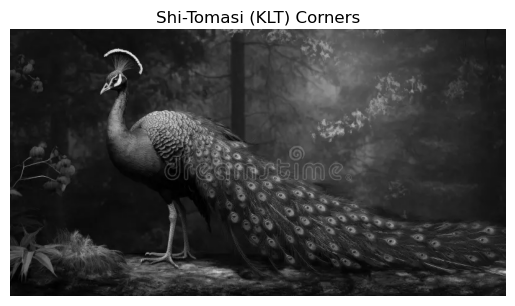

In [9]:
"""
advanced_classical_features.py

Implements:
1. Shi-Tomasi (KLT) corner response
2. FAST with scale-space selection
3. FAST with decision-tree (ML-style acceleration)
4. Rotation invariance repeatability test
5. Temporal consistency test on video frames

Designed for:
- Deep classical CV understanding
- Research & interview discussion
- Algorithmic clarity (not OpenCV wrappers)
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter, maximum_filter


# =============================================================================
#                        SHI–TOMASI (KLT) RESPONSE
# =============================================================================

def shi_tomasi_response(gray, sigma=1.5):
    Ix = sobel(gaussian_filter(gray, sigma), axis=1)
    Iy = sobel(gaussian_filter(gray, sigma), axis=0)

    Ixx = gaussian_filter(Ix * Ix, sigma)
    Iyy = gaussian_filter(Iy * Iy, sigma)
    Ixy = gaussian_filter(Ix * Iy, sigma)

    # Eigenvalues of structure tensor
    trace = Ixx + Iyy
    det = Ixx * Iyy - Ixy ** 2
    lambda_min = trace / 2 - np.sqrt((trace / 2) ** 2 - det)

    return lambda_min


# =============================================================================
#                          FAST (BASE + SCORE)
# =============================================================================

FAST_CIRCLE = [
    (0, 3), (1, 3), (2, 2), (3, 1), (3, 0), (3, -1), (2, -2), (1, -3),
    (0, -3), (-1, -3), (-2, -2), (-3, -1), (-3, 0), (-3, 1), (-2, 2), (-1, 3)
]

def fast_detector(gray, threshold=30, n=9):
    h, w = gray.shape
    keypoints = []

    for y in range(3, h - 3):
        for x in range(3, w - 3):
            c = gray[y, x]
            diffs = np.array([gray[y+dy, x+dx] - c for dx, dy in FAST_CIRCLE])

            bright = diffs > threshold
            dark = diffs < -threshold

            bright = np.r_[bright, bright]
            dark = np.r_[dark, dark]

            if (np.max(np.convolve(bright, np.ones(n), 'valid')) >= n or
                np.max(np.convolve(dark, np.ones(n), 'valid')) >= n):
                score = np.sum(np.abs(diffs))
                keypoints.append((y, x, score))

    return keypoints


# =============================================================================
#                       SCALE-SPACE FAST
# =============================================================================

def fast_scale_space(gray, scales=(1.0, 0.75, 0.5)):
    all_kp = []

    for s in scales:
        resized = cv2.resize(gray, None, fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
        kp = fast_detector(resized)

        for y, x, score in kp:
            all_kp.append((y / s, x / s, score, s))

    return all_kp


# =============================================================================
#               FAST WITH DECISION-TREE ACCELERATION
# =============================================================================

def fast_ml(gray, threshold=30):
    """
    Simplified ML-FAST:
    Early rejection using 4 → 8 → 12 pixel tests
    """
    h, w = gray.shape
    corners = []

    check4 = [0, 4, 8, 12]
    check8 = [0, 2, 4, 6, 8, 10, 12, 14]

    for y in range(3, h - 3):
        for x in range(3, w - 3):
            c = gray[y, x]

            if sum(abs(gray[y+FAST_CIRCLE[i][1], x+FAST_CIRCLE[i][0]] - c) > threshold for i in check4) < 3:
                continue

            if sum(abs(gray[y+FAST_CIRCLE[i][1], x+FAST_CIRCLE[i][0]] - c) > threshold for i in check8) < 6:
                continue

            diffs = np.array([gray[y+dy, x+dx] - c for dx, dy in FAST_CIRCLE])
            score = np.sum(np.abs(diffs))

            corners.append((y, x, score))

    return corners


# =============================================================================
#                     ROTATION INVARIANCE TEST
# =============================================================================

def rotation_repeatability(gray, angles=(5, 15, 30, 45)):
    base = fast_detector(gray)
    base_pts = {(y, x) for y, x, _ in base}

    results = {}

    for angle in angles:
        M = cv2.getRotationMatrix2D(
            (gray.shape[1] // 2, gray.shape[0] // 2),
            angle,
            1.0
        )
        rotated = cv2.warpAffine(gray, M, (gray.shape[1], gray.shape[0]))

        kp = fast_detector(rotated)
        kp_set = {(y, x) for y, x, _ in kp}

        common = base_pts & kp_set
        results[angle] = len(common) / max(1, len(base_pts))

    return results


# =============================================================================
#                     TEMPORAL CONSISTENCY TEST
# =============================================================================

def temporal_consistency(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    prev_pts = None
    stable_counts = []

    for _ in range(max_frames):
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        pts = {(y, x) for y, x, _ in fast_detector(gray)}

        if prev_pts is not None:
            stable = prev_pts & pts
            stable_counts.append(len(stable))

        prev_pts = pts

    cap.release()
    return stable_counts


# =============================================================================
#                                DEMO
# =============================================================================

def main():
    img = cv2.imread(r"C:\Users\11suj\Downloads\hd-wallpapers-peacock-forest-ai-hd-wallpapers-peacock-forest-306989017.webp", cv2.IMREAD_GRAYSCALE)

    # Shi-Tomasi
    klt = shi_tomasi_response(img)
    klt_nms = (klt == maximum_filter(klt, size=5)) & (klt > np.percentile(klt, 99.5))

    # FAST Scale Space
    fast_scales = fast_scale_space(img)

    # ML FAST
    fast_ml_pts = fast_ml(img)

    # Rotation Test
    rot_stats = rotation_repeatability(img)
    print("Rotation repeatability:", rot_stats)

    # Visualization
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for y, x in zip(*np.where(klt_nms)):
        cv2.circle(vis, (x, y), 3, (0, 255, 255), -1)

    plt.imshow(vis)
    plt.title("Shi-Tomasi (KLT) Corners")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    main()
